In [5]:
!pip install darts

In [6]:
import logging
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm
from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel
from darts.metrics import mape
from darts.datasets import IceCreamHeaterDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression

warnings.filterwarnings("ignore")
logging.disable(logging.CRITICAL)

<Axes: xlabel='Month'>

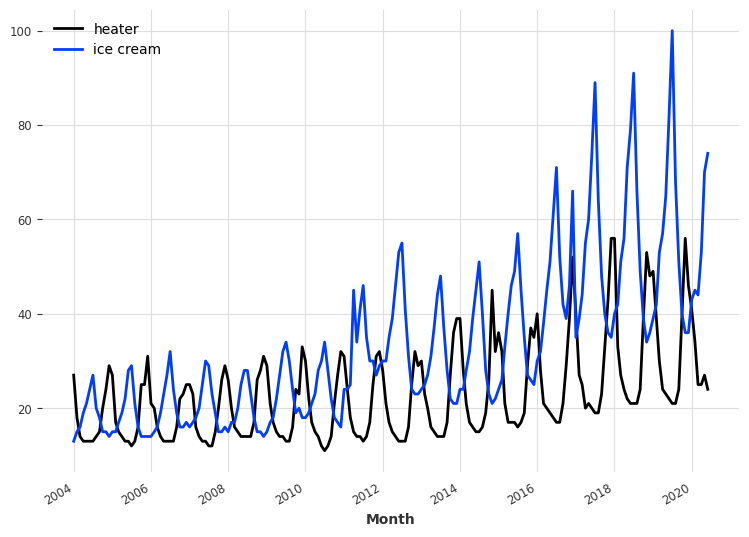

In [7]:
series_ice_heater = IceCreamHeaterDataset().load()

figsize = (9, 6)
plt.figure(figsize=figsize)
series_ice_heater.plot()

In [8]:
series_ice_heater

<TimeSeries (DataArray) (Month: 198, component: 2, sample: 1)>
array([[[ 27.],
        [ 13.]],

       [[ 18.],
        [ 15.]],

       [[ 14.],
        [ 16.]],

       [[ 13.],
        [ 19.]],

       [[ 13.],
        [ 21.]],

       [[ 13.],
        [ 24.]],

       [[ 13.],
        [ 27.]],
...
       [[ 46.],
        [ 36.]],

       [[ 41.],
        [ 43.]],

       [[ 34.],
        [ 45.]],

       [[ 25.],
        [ 44.]],

       [[ 25.],
        [ 53.]],

       [[ 27.],
        [ 70.]],

       [[ 24.],
        [ 74.]]])
Coordinates:
  * Month      (Month) datetime64[ns] 2004-01-01 2004-02-01 ... 2020-06-01
  * component  (component) object 'heater' 'ice cream'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [9]:
# define train/validation cutoff time
training_cutoff_ice = series_ice_heater.time_index[-24]
print(training_cutoff_ice)

# use ice cream sales as target, create train and validation sets and transform data
series_ice = series_ice_heater["ice cream"]
train_ice, val_ice = series_ice.split_before(training_cutoff_ice)

ice_scaler = Scaler()
train_ice_transformed = ice_scaler.fit_transform(train_ice)
val_ice_transformed = ice_scaler.transform(val_ice)
series_ice_transformed = ice_scaler.transform(series_ice)

# use heater sales as past observed data
observed_heat = series_ice_heater["heater"]
heat_train, heat_val = observed_heat.split_before(training_cutoff_ice)

transformer_heat = Scaler()
transformer_heat.fit(heat_train)
observed_heat_transformed = transformer_heat.transform(observed_heat)

2018-07-01 00:00:00


In [10]:
# use `add_encoders` as we don't have future inputs
my_model_ice = TFTModel(
    input_chunk_length=36,
    output_chunk_length=12,
    hidden_size=32,
    lstm_layers=1,
    batch_size=16,
    n_epochs=300,
    dropout=0.1,
    add_encoders={"cyclic": {"future": ["month"]}},
    add_relative_index=False,
    optimizer_kwargs={"lr": 1e-3},
    random_state=42,
)

# fit the model with past covariates
my_model_ice.fit(
    train_ice_transformed, past_covariates=observed_heat_transformed, verbose=True
)

Training: 0it [00:00, ?it/s]

TFTModel(hidden_size=32, lstm_layers=1, num_attention_heads=4, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=None, likelihood=None, norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=36, output_chunk_length=12, batch_size=16, n_epochs=300, add_encoders={'cyclic': {'future': ['month']}}, optimizer_kwargs={'lr': 0.001}, random_state=42)

Predicting: 0it [00:00, ?it/s]

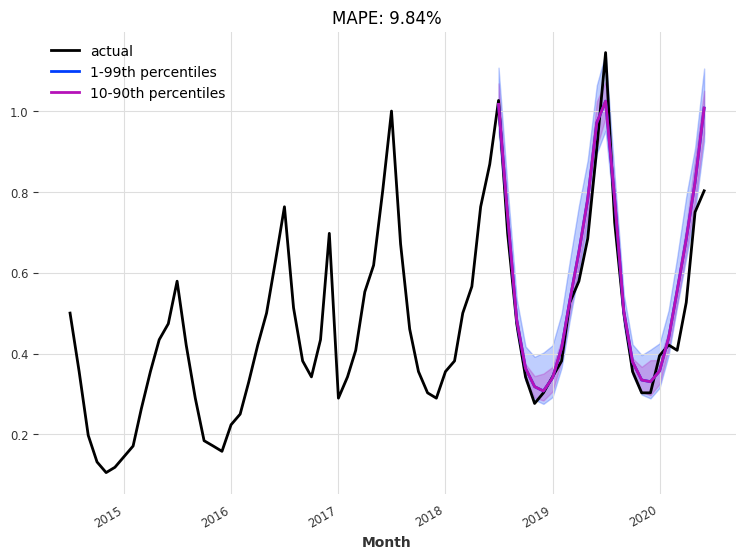

In [11]:
num_samples = 200
lowest_q, low_q, high_q, highest_q = 0.01, 0.1, 0.9, 0.99
label_q_outer = f"{int(lowest_q * 100)}-{int(highest_q * 100)}th percentiles"
label_q_inner = f"{int(low_q * 100)}-{int(high_q * 100)}th percentiles"

def eval_model(model, n, actual_series, val_series):
    pred_series = model.predict(n=n, num_samples=num_samples)

    # plot actual series
    plt.figure(figsize=figsize)
    actual_series[: pred_series.end_time()].plot(label="actual")

    # plot prediction with quantile ranges
    pred_series.plot(
        low_quantile=lowest_q, high_quantile=highest_q, label=label_q_outer
    )
    pred_series.plot(
        low_quantile=low_q, high_quantile=high_q, label=label_q_inner
    )
    plt.title("MAPE: {:.2f}%".format(mape(val_series, pred_series)))
    plt.legend()

eval_model(
    model=my_model_ice,
    n=24,
    actual_series=series_ice_transformed[
        train_ice.end_time() - (2 * 24 - 1) * train_ice.freq :
    ],
    val_series=val_ice_transformed,
)

Predicting: 0it [00:00, ?it/s]

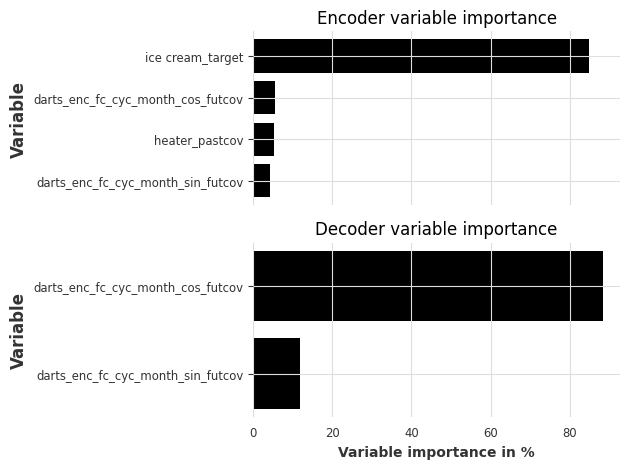

In [12]:
from darts.explainability import TFTExplainer

explainer = TFTExplainer(my_model_ice)
results = explainer.explain()
explainer.plot_variable_selection(results)

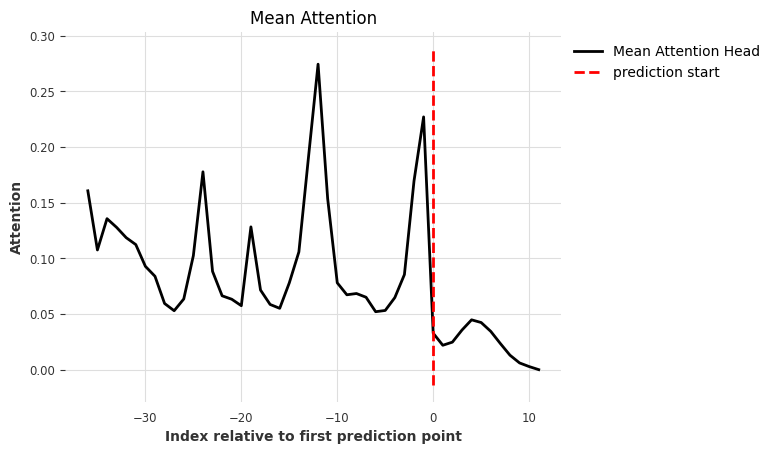

<Axes: title={'center': 'Mean Attention'}, xlabel='Index relative to first prediction point', ylabel='Attention'>

In [13]:
explainer.plot_attention(results, plot_type="time")